<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Autoencoders/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

Autoencoders are used for unsupervised learning. The primary goal is to learn efficient representations of data, typically by compressing the input into a lower-dimensional latent space and then reconstructing the input from that representation.

### Autoencoder components

#### Encoder

Encoders compress the input to a lower dimensional representation (latent space). Consists of several or more layers that reduce diemnsions.

#### Latent space

Lower-dim representation of inputs. Basically - condensed information.

#### Decoder

Reconstructs the data form latent space, mirrors encoder structure in reverse.

## Part 1 - smiles [10 points]

### Data preparation [1 point]

#### Imports

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import skimage.io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

from copy import deepcopy
from google.colab import userdata, files
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets
from typing import Callable, Dict, List, Tuple


%matplotlib inline

#### Set config

In [41]:
class CFG:
  seed = 42
  batch_size = 32
  inch=32
  latent_dim=512
  momentum = 0.1
  lr = 1e-4
  epochs=1
  weight_decay = 1e-5
  eps=1e-10
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'

#### Freeze seeds

In [3]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = True

def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [4]:
seed_everything()

#### Set WandB

In [ ]:
def init_wandb():
  try:
    CFG.wandbapi = userdata.get('wandb')
    project="Semantic_segmentation_dermoscopic"
    entity='dimildizio'
    wandb.login(key=CFG.wandbapi)

  except Exception as e:
    print(e)

In [ ]:
def wandb_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for integrating with Weights & Biases (wandb).

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        print('wrapper works')
        if CFG.wandbapi:
            wandb.init(project=project, entity=entity, config=wandb_config())
            print('Logging wandb')
        try:
          result = func(*args, **kwargs)
        except Exception as e:
          if CFG.wandbapi:
            wandb.log({"error_message": str(e)}, commit=False)
            wandb.finish()
          raise e
        finally:
          if CFG.wandbapi:
            wandb.finish()
        return result
    return wrapped_function

#### Download data

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    gc.collect()
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                #.apply(lambda img: resize(img,[dimx,dimy]))

    #all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    all_names = df['person']

    return all_photos, all_attrs, all_names

def resize_images(data):
  resized = data.apply(lambda img: resize(img.astype(np.float32), [128, 128]))
  gc.collect()
  return np.stack(resized.values)


In [6]:
data, attrs, names = fetch_dataset()
gc.collect()
data = resize_images(data)
gc.collect()

#### Display images

In [19]:
def display_images(images, labels, ncols=6, figsize=(22, 6)):
    """
    Display a grid of images with corresponding labels.

    Args:
        images (np.ndarray): Numpy array of shape (num_images, height, width, channels).
        labels (pd.Series): Pandas Series containing labels for each image.
        ncols (int): Number of columns in the grid.
        figsize (tuple): Figure size.

    Returns:
        None
    """
    num_images = len(images)
    nrows = int(np.ceil(num_images / ncols))

    fig, ax = plt.subplots(nrows=3, ncols=6, figsize=figsize, sharey=True, sharex=True)

    for fig_x in ax.flatten():
        idx = random.randrange(0, num_images)
        fig_x.imshow(images[idx])
        plt.xticks([])
        plt.yticks([])
        fig_x.set_title(labels.iloc[idx])
        plt.grid(True)
    plt.tight_layout()

    plt.show()

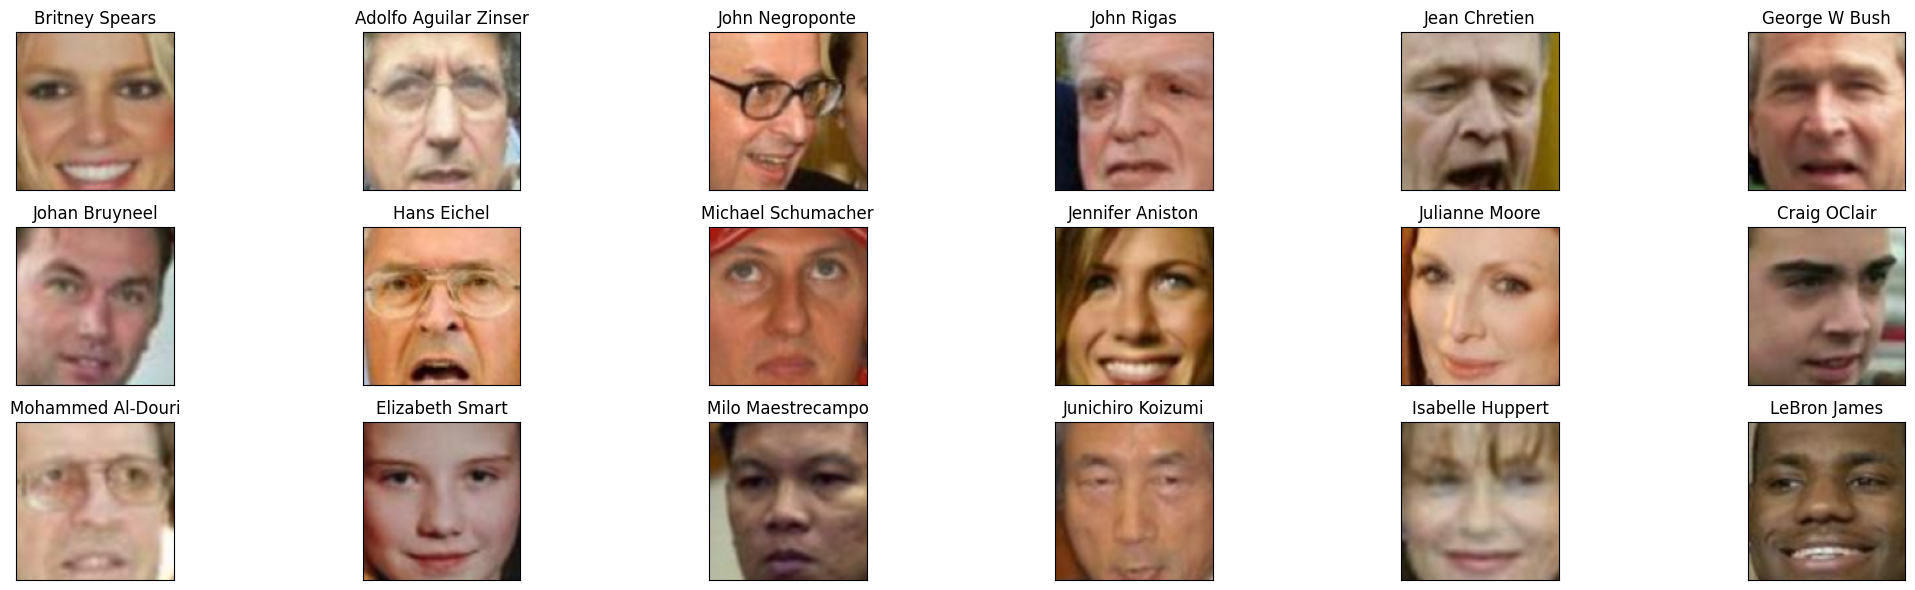

In [20]:
display_images(data, names)

#### Split into train and val data

In [21]:
X_train_arr, X_val_arr, y_train_arr, y_val_arr = train_test_split(data, attrs, test_size=0.2, random_state=CFG.seed)

#### Load data

In [22]:
def data_load(array):
  '''
  Convert array to tensor, rearrange to [batch, channels, height, width]
  and return DataLoader instance
  '''
  tensored = torch.FloatTensor(array).permute(0, 3, 1, 2)
  loader = DataLoader(tensored, batch_size=CFG.batch_size, num_workers=2)
  return loader

In [23]:
X_train = data_load(X_train_arr)
X_val = data_load(X_val_arr)

### Model architecture

Autoencoder converts input data to a lower-dimension representation (latent space): $$h = f_{encoder}(x)$$

After that the latent space is passed to the decoder which tries to reconstruct the input data: $$x'= f_{decoder}(h)$$

![autoencoder architecture](https://topapps.ai/wp-content/uploads/2023/05/image-84.png)

pic from [this article](https://topapps.ai/nudifying-ai-tools-and-other-problems-with-deepfake-artificial-intelligence-technology/)

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">



### Model class

In [108]:
class Autoencoder_1(nn.Module):
  def __init__(self):
    super(Autoencoder_1, self).__init__()
    self.hw=CFG.inch//2
    self.ouch_1 = CFG.inch * 2
    self.ouch_2 = ouch_1 * 2
    self.linch=linch = CFG.inch**3

    self.encoder = nn.Sequential(
        self.get_enc(3, CFG.inch),
        self.get_enc(CFG.inch, self.ouch_1),
        self.get_enc(self.ouch_1, self.ouch_2),
        nn.Flatten(start_dim=1),
        nn.Linear(self.linch, CFG.latent_dim),
    )

    self.decoder = nn.Sequential(
        nn.Linear(CFG.latent_dim, self.linch),
        nn.Unflatten(dim=1, unflattened_size=(self.ouch_2, self.hw, self.hw)),
        self.get_dec(self.ouch_2, self.ouch_1),
        self.get_dec(self.ouch_1, CFG.inch),
        nn.ConvTranspose2d(in_channels=CFG.inch,
                           out_channels=3,
                           kernel_size=3,
                           stride=2,
                           padding=1,
                           output_padding=1),
        nn.Sigmoid())


  def get_dec(self, inch, ouch, stride=2, padding=1):
    layer = nn.Sequential(
        nn.ConvTranspose2d(in_channels=inch,
                           out_channels=ouch,
                           kernel_size=3,
                           stride=stride,
                           padding=padding,
                           output_padding=1),
        nn.BatchNorm2d(ouch, momentum=CFG.momentum),
        nn.ReLU()
    )
    return layer


  def get_enc(self, inch, ouch, stride=2, padding=1):
    layer = nn.Sequential(
        nn.Conv2d(in_channels=inch,
                  out_channels=ouch,
                  kernel_size=3,
                  stride=stride,
                  padding=padding),
        nn.BatchNorm2d(ouch, momentum=CFG.momentum),
        nn.ReLU(),
    )
    return layer


  def forward(self, x):
    x = self.encoder(x)
    rec = self.decoder(x)
    return rec, x

In [104]:
summary(Autoencoder_1(), (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 512]      16,777,728
           Linear-12                [-1, 32768]      16,809,984
        Unflatten-13          [-1, 128, 16, 16]               0
  ConvTranspose2d-14           [-1, 64,

### Train

In [97]:
class Trainer:
  def __init__(self, model=False, optimizer=False, loss_fn=False, scheduler=False):
    self.loss_fn = nn.MSELoss()
    self.model = model or Autoencoder_1()
    self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(),
                                                 lr=CFG.lr, eps=CFG.eps,
                                                 weight_decay=CFG.weight_decay,
                                                 betas=(.9, .999),
                                                 amsgrad=True)
    self.scheduler = scheduler or torch.optim.lr_scheduler.ExponentialLR(
                                                      self.optimizer, gamma=.95)
    self.best_val = float('inf')
    self.best_weights = None
    self.history = {'train_loss':[],
                    'val_loss':[]}


  def train(self, trainloader, valloader):
    for epoch in range(CFG.epochs):
      train_loss = self.train_epoch(trainloader)
      val_loss = self.val_epoch(valloader)
      self.scheduler.step()
      self.write_history(train_loss, val_loss)
      del train_loss, val_loss
      gc.collect()
      return self.history


  def train_epoch(self, loader):
    train_epoch_loss = []
    self.model.train()
    for image in loader:
      self.optimizer.zero_grad()
      image = image.to(CFG.device())
      reconstructed, encoded = self.model(image)
      loss = self.loss_fn(reconstructed, image)
      loss.backward()
      self.optimizer.step()
      train_epoch_loss.append(loss.item())

    del image
    del reconstructed
    gc.collect()
    return np.mean(train_epoch_loss)


  def val_epoch(self, valloader):
    val_epoch_loss = []
    self.model.eval()
    with torch.no_grad():
      for image in valloader:
        image = image.to(CFG.device())
        reconstructed, encoded = self.model(image)
        loss = self.loss_fn(reconstructed, image)
        val_epoch_loss.append(loss.item())
    del image
    del reconstructed
    gc.collect()
    return np.mean(val_epoch_loss)


  def write_history(self, tr, vl):
    self.history['train_loss'].append(tr)
    self.history['val_loss'].append(vl)
    self.save_best_model(vl)


  def save_best_model(self, val_loss):
    if val_loss < self.best_val:
      self.best_val = val_loss
      self.best_weights = deepcopy(self.model.state_dict())

In [110]:
tr = Trainer(model = Autoencoder_1().to(CFG.device()))

In [113]:
result_history=tr.train(X_train, X_val)
result_history

{'train_loss': [0.02023580331372318], 'val_loss': [0.0072867863093424275]}

In [114]:
#del tr
gc.collect()

0